# Problem 0

### You will get 0 for the whole pset unless you finish this problem :)

You were invited to Piazza, where you can find [announcement](https://piazza.com/class/iuiaquv3t0y6vy?cid=8) on the course project. In case you didn't get an invitation to your @skoltech.ru email from Piazza, ask TA to set you up there. 
* Register in Piazza with your @skoltech.ru email.
* Find a post with [homework rules](https://piazza.com/class/iuiaquv3t0y6vy?cid=9) on piazza and read it carefully. <font color='red'>If you do not follow it you will likely be penalized.</font>
* Write a private post to TA in Piazza describing your background in mathematics (e.g. courses you took and enjoyed, etc). 

# Problem 1 (Python demo)

## 45 pts

## Data preparation

* First of all download $\verb|.wav|$ file with starcraft sound from [here](TMaRdy00.wav). Load it in python and play using functions from [demo](bss1.ipynb).

Our next goal is to process this signal by multiplying it by a special type of matrix (convolution operation) that will smooth the signal. 

* Before processing this file let us estimate what size of matrix we can afford. Let $N$ be the size of the signal. Estimate analytically memory in megabytes required to store dense square matrix of size $N\times N$ to fit in your operation memory and print this number. Cut the signal so that you will not have swap (overflow of the operation memory). **Note:** Cut the signal by taking every p-th number in array: ```signal[::p]```. 


* Write function ```gen_toeplitz```($N,\alpha$) that outputs matrix $T$: $$T_{ij} = \sqrt{\frac{\alpha}{\pi}}e^{-\alpha (i-j)^2}, \quad i,j=1,\dots,N$$ as numpy array. Avoid using loops or lists! The function [scipy.linalg.toeplitz](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.toeplitz.html) might be helpful for this task.
**Note:** matrices that depend only on difference of indices: $T_{ij} \equiv T_{i-j}$ are called **Toeplitz**. Toeplitz matrix-by-vector multiplication is **convolution** since it can be written as $y_i = \sum_{j=1}^N T_{i-j} x_j$. It can be done faster than $\mathcal{O}(N^2)$ complexity using Fast Fourier transform (will be covered later in our course, no need to implement it here).

## Convolution

* Multiply matrix $T$ by your signal (for matvec operations use $\verb|numpy|$ package). Plot the first $100$ points of the result and the first $100$ points of your signal on the same figure. Do the same plots for $\alpha = \frac{1}{5}$, $\alpha = \frac{1}{100}$ using ```plt.subplots``` in matplotlib. Make sure that you got results that look like slighly smoothed initial signal.


* Play the resulting signal. In order to do so format your array into $\verb|int16|$ before playing by using
```python
your_array = your_array.astype(np.int16)
```

## Recovering signal from its convolution

Given convolved signal $y$ and initial signal $x$ our goal now is to recover $x$ by solving the system
$$
    y = Tx.
$$
To do so we will run iterative process
$$
    x_{k+1} = x_{k} - \tau_k (Tx_k - y), \quad k=1,2,\dots
$$
starting from zero vector $x_0$. There are different ways how to define parameters $\tau_k$.
Different choices lead to different methods (e.g. Richardson iteration, Chebyshev iteration, etc.).
This topic will be covered in details later in our course.

To get some intuition why this process converges to the solution of $Tx=y$ we can have the following considerations. Let us note that if  $x_k$ converges to some limit $x$, then so does $x_{k+1}$ and taking $k\to \infty$ we arrive at $x = x - \tau (Tx -  y)$ and hence $x$ is the solution of $Tx = y$. 

Another important point is that iterative process require only matrix-vector porducts $Tx_k$ on each iteration instead of the whole matrix. In this problem we, however, work with the full matrix, but keep in mind, that convolution can be done efficiently without storing the whole matrix.

* For each $k$ choose paremeter $\tau_k$ such that the residual $r_{k+1}=Tx_{k+1} - y$ is minimal possible (*line search* with search direction $r_k$):
$$
    \|Tx_{k+1} - y\|_2 \to \min_{\tau_k}
$$
found analytically. The answer to this bullet is derivation of $\tau_k$. $\tau_k$ should be expressed in terms of residuals $r_k = T x_k - y$.

* Write a function ```iterative(N, num_iter,``` $\alpha$) that outputs accuracy numpy array of relative errors $\big\{\frac{\|x_{k+1} - x\|}{\|x\|}\big\}$ after ```num_iter``` iterations using $\tau_k$ from the previous task. Set ```num_iter=1000``` and do a convergence plot for $\alpha = \frac{1}{2}$ and $\alpha = \frac{1}{5}$. **Note:** The only loop you are allowed to use here is a loop for $k$.

* Explain what happens with the convergence if you add small random noise to $y$. The answer to this question should be an explanation supported by plots and/or tables.

# Solution

In [6]:
#Tech stuff
import scipy
from scipy.io import wavfile
from scipy.signal import resample
import numpy as np
%matplotlib inline
import sys
def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

In [7]:
#Reading the wavefile
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display
def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

C:\Users\Evgeny\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


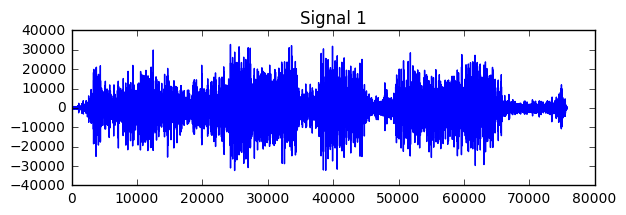

In [8]:
#The first sound
import pylab as pl
import numpy as np
# load
fs1,s1 = load_wav('TMaRdy00.wav') # Terran Battlecruiser - "Good day, commander."

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Signal 1')
pl.show()

# player
wavPlayer(s1, fs1)

In [9]:
megabytes = s1.dtype.itemsize * len(s1) / float(10**6)
print megabytes


0.151552


In [10]:
def gen_toeplitz(N, a):
    
    # Array generating
    T = np.arange(N) 
    
    # Generating matrix Tij = |i-j|
    Tij = scipy.linalg.toeplitz(T) 
    
    # Matrix Tij = (i-j)^2
    Tij = Tij * Tij 
    
    # Requaired matrix
    Tij = np.sqrt(a / np.pi) * np.exp (- a * Tij)
    return Tij

In [11]:
# Signal cutting

p = 20
signal_pcut = s1[::p] 

# Convolution 

In [45]:
# Generating Toeplitz matrix with a = 0.2
T1 = gen_toeplitz(len(signal_pcut), 0.2) 

# Generating Toeplitz matrix with a = 0.01
T2 = gen_toeplitz(len(signal_pcut), 0.01) 

In [46]:
# Multiplying signal by Toeplitz matrix with a = 0.2
T1_dot_signal_pcut = np.dot(T1, signal_pcut) 

# Multiplying signal by Toeplitz matrix with a = 0.01
T2_dot_signal_pcut = np.dot(T2, signal_pcut) 

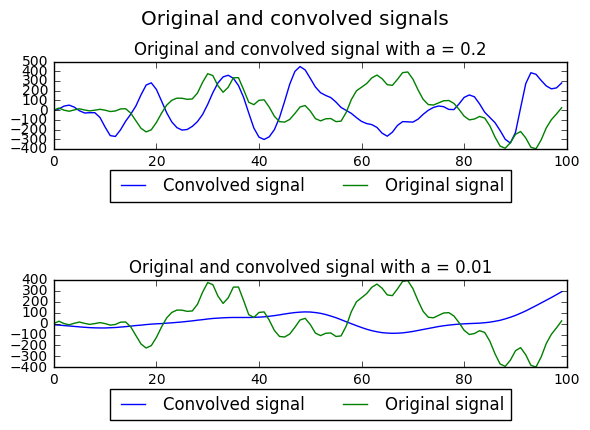

In [107]:
fig = pl.figure()
title = fig.suptitle("Original and convolved signals", fontsize="x-large")

compare1 = fig.add_subplot(2,1,1)
compare1.plot(T1_dot_signal_pcut[:100], label = 'Convolved signal')
compare1.plot(s1[:100], label = 'Original signal')
compare1.set_title('Original and convolved signal with a = 0.2')
compare1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

compare2 = fig.add_subplot(2,1,2)
compare2.plot(T2_dot_signal_pcut[:100], label = 'Convolved signal')
compare2.plot(s1[:100], label = 'Original signal')
compare2.set_title('Original and convolved signal with a = 0.01')
compare2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

pl.tight_layout()
fig.subplots_adjust(top=0.85, hspace=1.5)
pl.show()

In [24]:
frequency = fs1 / p

In [ ]:
T1_dot_signal_pcut = T1_dot_signal_pcut.astype(np.int16)
wavPlayer(T1_dot_signal_pcut, frequency)

In [ ]:
T2_dot_signal_pcut = T2_dot_signal_pcut.astype(np.int16)
wavPlayer(T2_dot_signal_pcut, frequency)

# Deconvolution

We have an optimization problem


$$||Tx_{k+1} - y|| \rightarrow \min{\tau_k}$$


Substituting the expression for $x_{k+1}$ in $||Tx_{k+1} - y||^2$ we obtain


$$||Tx_{k+1} - y||^2 = \langle r_k, r_k\rangle - 2\tau_k\langle r_k, Tr_k\rangle + \tau_k^2\langle Tr_k, Tr_k\rangle$$


Taking a derivative with respect to $\tau_k$ and putting it to zero we obtain


$$\tau_k\langle Tr_k, Tr_k\rangle = \langle r_k, Tr_k\rangle$$


So we can find an optimal point $\tau_k$


$$\tau_k = \frac{\langle r_k, Tr_k\rangle}{\langle Tr_k, Tr_k\rangle}$$

In [18]:
def iterative(N, num_iter, y, a):
    T = gen_toeplitz(N, a)
    x = np.dot(np.linalg.inv(T), y)
    x_iter = np.zeros(N)
    err = []
    for i in range(num_iter):
        r = T.dot(x_iter) - y
        T_dot_r = T.dot(r)
        tau = r.dot(T_dot_r) / (T_dot_r.dot(T_dot_r))
        x_iter = x_iter - tau * r
        err.append(np.linalg.norm(x_iter - x)/np.linalg.norm(x))
    return np.array(err)

In [19]:
# Computing for a = 0.5

N, a = len(signal_pcut), 0.5

#In this case y = Toeplitz(N, a) * signal_pcut
T = gen_toeplitz(N, a)
y = np.dot(T, signal_pcut)

# So we obtain an array of mistakes
err1 = iterative(N, 1000, y, a)

In [20]:
# Computing for a = 0.2

N, a = len(signal_pcut), 0.2

#In this case y = Toeplitz(N, a) * signal_pcut
T = gen_toeplitz(N, a)
y = np.dot(T, signal_pcut)

# So we obtain an array of mistakes
err2 = iterative(N, 1000, y, a)

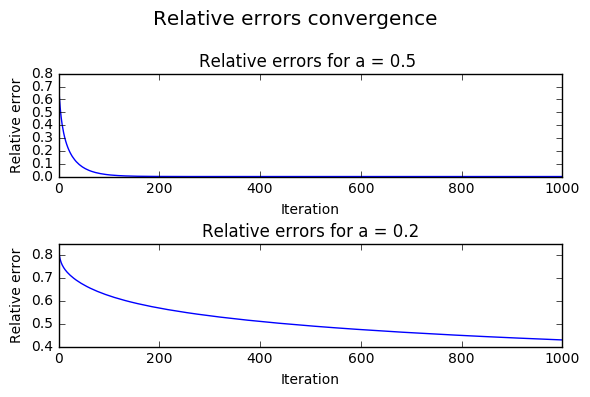

In [40]:
# Plots
fig = pl.figure()
title = fig.suptitle("Relative errors convergence", fontsize="x-large")

errplot1 = fig.add_subplot(2,1,1)
errplot1.plot(err1)
errplot1.set_title('Relative errors for a = 0.5 ')
errplot1.set_xlabel('Iteration')
errplot1.set_ylabel('Relative error')

errplot2 = fig.add_subplot(2,1,2)
errplot2.plot(err2)
errplot2.set_title('Relative errors for a = 0.2')
errplot2.set_xlabel('Iteration')
errplot2.set_ylabel('Relative error')

pl.tight_layout()
fig.subplots_adjust(top=0.82)
pl.show()

In [24]:
N = len(signal_pcut); a = 0.2

#Generating a Toeplitz matrix and y
T = gen_toeplitz(N, a)
y = np.dot(T, signal_pcut)

#Adding a random noise
y += np.random.normal(0, max(signal_pcut) * 0.001, N)

#Mistakes array
err_noised = iterative(N, 1000, y, a)

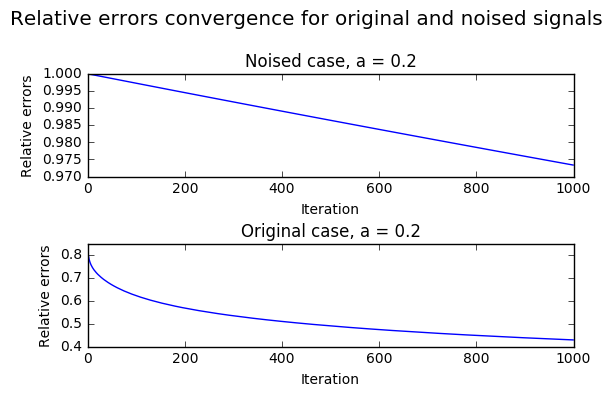

In [42]:
# Plots

fig = pl.figure()
title = fig.suptitle("Relative errors convergence for original and noised signals", fontsize="x-large")

errplot_noised = fig.add_subplot(2,1,1)
errplot_noised.plot(err_noised)
errplot_noised.set_title('Noised case, a = 0.2')
errplot_noised.set_xlabel('Iteration')
errplot_noised.set_ylabel('Relative errors')


errplot2 = fig.add_subplot(2,1,2)
errplot2.plot(err2)
errplot2.set_title('Original case, a = 0.2')
errplot2.set_xlabel('Iteration')
errplot2.set_ylabel('Relative errors')

pl.tight_layout()
fig.subplots_adjust(top=0.82)
pl.show()

# Problem 2 (Theoretical tasks)

## Unitary invariance

## 15 pts

* Prove that the second vector norm $\|\cdot\|_2$ is unitary invariant: $\|Ux\|_2 = \|x\|_2$ holds for any unitary matrix $U$ and any vector $x$. 


* Prove that the spectral matrix norm $\|\cdot\|_2$ is unitary invariant: $\|UAV\|_2 \equiv \|A\|_2$ holds for any unitary matrices $U$ and $V$ and for any matrix $A$. **Hint:** use definition of the operator norm.


* In order to prove unitary invariance of the Frobenius norm prove first that $\|A\|^2_F = \text{trace}(AA^*) = \text{trace}(A^*A)$.
Now prove that the Frobenius norm is unitary invariant. You can use the following property of the trace: $\text{trace}(BC) \equiv \text{trace}(CB)$

## SVD

## 15 pts

* Prove that $\|A\|_2 = \sigma_1(A)$ and $\|A\|_F = \sqrt{\sigma_1^2(A) + \dots + \sigma_r^2(A)}$. **Note:** unitary invariance of the second and Frobenius norms might be helpful.


* Matrix norm $\|A\|_* = \sigma_1(A) + \dots + \sigma_r(A)$ is called *nuclear norm* and plays important role in approximation by low-rank matrices. Check if it is unitary invariant.


* Find the distance in second and Frobenius norms between nonsingular matrix and the closest singular.

# Solution
## Unitary invariance

1) $$||Ux||_2 = \langle Ux , Ux\rangle = x^* U^*Ux = x^*x = ||x||_2$$


2) $$||UAV||_2 = \max_{||x||\neq 0 }\frac{||UAVx||_2}{||x||_2} = \max_{||x||\neq 0 }\frac{x^*V^*A^*U^*UAVx}{||x||_2} =\max_{||x||\neq 0 }\frac{x^*V^*A^*AVx}{||x||_2} =  \max_{||x||\neq 0 }\frac{||AVx||}{||x||_2} = \max_{||x||\neq 0 }\frac{||AVx||_2}{||Vx||_2} = \max_{||x||\neq 0 }\frac{||Ax||_2}{||x||_2}$$

3) $$(AB)_{ij} = \sum_k A_{ik}B_{kj}\Rightarrow(AA^*)_{ij} = \sum_k A_{ik}\overline{A_{jk}}$$

so the trace of $AA^*$ is

$$trace(AA^*) = \sum_i (AA^*)_{ii} = \sum_i \sum_k A_{ik}\overline{A_{ik}} = \sum_{i,k} |A_{ik}|^2 = ||A||_F^2.$$


Here is a proof of $trace(AB) = trace(BA)$:


$$trace(AB) = \sum_i (AB)_{ii} = \sum_i \sum_k A_{ik}B_{ki} = \sum_k \sum_i A_{ik}B_{ki} = \sum_k \sum_i B_{ki}A_{ik} = \sum_k (BA)_{kk} = trace(BA)$$


4) $$||UAV||_F^2 = trace(UAVV^*A^*U^*) = trace(UAA^*U^*) = trace(A^*U^*UA) = trace(A^*A) = trace(AA^*) = ||A||_F^2$$

## SVD

1) Spectral norm:

$$\max_{||x||_2\neq 0 }\frac{||Ax||_2}{||x||_2} = \max_{||x||_2\neq 0 }\frac{\sqrt{\langle Ax, Ax\rangle}}{||x||_2} = \max_{||x||_2\neq 0 }\frac{\sqrt{\langle x, A^*Ax\rangle}}{||x||_2} = \max_{||x||_2\neq 0 }\frac{\sqrt{||x||_2\cdot||A^*Ax||_2\cdot \cos(\alpha)}}{||x||_2}$$

where $\alpha$ - is an angle between vectors $x$ and $A^*Ax$. Obviously, the maximun is obtained when $\cos(\alpha)=1$. This case is achieved when $x$ is an eigenvector of $A^*A$. Finally, we have to choose eigenvector with $\lambda_{max}$. So we obtain

$$\max_{||x||_2\neq 0 }\frac{||Ax||_2}{||x||_2} = \sqrt{\lambda_{max}(A^*A)} = \sigma_1(A)$$

Frobenius norm:

$$||A||_F = \sqrt{trace(A^*A)} = \sqrt{\sum_i \lambda_i(A^*A)} = \sqrt{\sum_i \sigma_i(A)^2}$$


2) Unitary invariance of nuclear norm:

$$||UAV||_* = \sum_i \sqrt{\lambda_i(V^*A^*U^*UAV)} = \sum_i \sqrt{\lambda_i(V^*A^*AV)}$$

If $x$ is an eigenvector of $V^*A^*AV$ then $Vx$ is an eigenvector of $A^*A$, more precisely 

$$V^*A^*AV = \lambda x\Rightarrow (AA^*)Vx = \lambda Vx$$


Hence,

$$||UAV||_* = \sum_i \sqrt{\lambda_i(V^*A^*AV)} = \sum_i \sqrt{\lambda_i(AA^*)} = ||A||_*$$

**Bonus**:

* $$||A||_* = 0\Rightarrow \lambda_i(A^*A) = 0,\ \forall i\ \ \Rightarrow trace(A^*A) = 0\Rightarrow \sum_{i,j}|(A)_{ij}|^2 = 0 \Rightarrow A_{ij} = 0$$

* $$||\alpha A||_* = \sum_i \sqrt{\lambda_i(|\alpha|^2 A^*A)} = \sum_i \sqrt{|\alpha|^2 \lambda_i(A^*A)} = \sum_i |\alpha| \sqrt{ \lambda_i(A^*A)} = |\alpha| \sum_i \sqrt{ \lambda_i(A^*A)} = |\alpha| \cdot ||A||_*$$

3)Spectral norm:

Let $A$ be a non singular $m\times n$ ($m>n$) matrix and $B$ be a $m\times n$ matrix of rank $k<n$. Let $\{v_1,\dots, v_{k+1}\}$ be a orthonormal left singular vectors (it is always possible to find such vectors), more precisely

$$Av_i = \sigma_iu_i,\ \|v_i\|=1,\ \|u_i\|=1$$
$$\sigma_1\geq\sigma_2\geq\dots\sigma_n>0$$

Due to singularity of $B$, $Ker(B)$ is $(n-k)$-dimensional vector space, hence, $span(v_1,\dots,v_{k+1})\cap Ker(B)\neq\emptyset$. Let $w = \sum_i c_iv_i$ be a unit vector from this intersection, in other words $\sum_i |c_i|^2 = 1$. So we have

$$\|(A-B)w\|^2_2 = \|Aw\|^2_2 =\sum_i \sigma_ic_i\|^2\geq \sigma^2_{k+1}\sum_i|c_i|^2 = \sigma_{k+1}^2$$

So we obtain

$$\|A-B\|_2\geq\frac{\|(A-B)w\|_2}{\|w\|_2}\geq\sigma_{k+1}$$

If $A = U\Sigma V^T$ then equality is achived in the case $B = A_k = U\Sigma_k V^T$, where $\Sigma_k = diag(\sigma_1,\dots,\sigma_{k},0,\dots,0)$. Indeed,

$$\|A-A_k\|_2 = \|U(\Sigma - \Sigma_k)V^T\|_2 = \|\Sigma - \Sigma_k\|_2 = \sigma_{k+1}$$

So the closest singular matrix is $A_{n-1}$ and

$$\|A-A_{n-1}\|_2 = \sigma_{min}(A)$$

Frobenius norm:

Let $A = U\Sigma V^T$ be a non singular $m\times n$ matrix and $B$ be a $m\times n$ matrix of rank $k$. Then

$$\|A-B\|_F = \|U\Sigma V^T - B\|_F = \|\Sigma - U^TBV\|_F$$

Obviously, we can only consider a case of diagonal matrix $U^TBV$. Otherwise, set $U^TBV = D + O$, where $D$ is diagonal matrix and $O$ is off-diagonal matrix. then

$$\|\Sigma - U^TBV\|^2_F = \sum_i (\sigma_i - D_{ii})^2 + \sum_{i\neq j}O_{ij}^2\geq \sum_i (\sigma_i - D_{ii})^2 = \|\Sigma - D\|^2_F = \|\Sigma - U^T(UDV^T)V\|^2_F$$

Hence, we consider the case of diagonal matrix $D = diag(d_1,d_2,\dots,d_k,0,\dots,0)$

$$\|\Sigma - D\|_F = \sqrt{\sum_{i=1}^k (\sigma_i - d_i)^2 + \sum_{i = k+1}^n\sigma_i^2}$$

Obviously, the minimum of the expression is achieved when $d_i = \sigma_i$ and equals

$$\min_{rank(B)=k}\|A-B\|_F = \sqrt{\sum_{i=k+1}^n\sigma_i^2}$$

So the closest singular matrix is $A_{n-1}$ and 
$$\|A-A_{n-1}\|_F = \sigma_{min}(A)$$

# Problem 3 (Strassen algorithm)

## 15 pts

* What is the complexity of naive matrix-matrix multiplication? What is the complexity of Strassen algorithm? Can complexity of matrix-matrix multiplication be asymptotically smaller than $\mathcal{O}(n^2)$? Why?

It might be a good idea not to do recursion in the Strassen algorithm to the bottom level. Sometimes only several levels of the recursion are used. This helps to reduce a constant outside $n^3$. 

* Find analytically constant outside $n^3$ after $2$ levels of recursion in Strassen algorithm. Compare it with the constant in the naive multiplication. **Note:** additions and multiplications of numbers are assumed to have the same computational cost.

# Solution

* As was mentioned on lecture complexities of naive and Strassen algorithms are $O(n^3)$ and $O(n^{\log_27})$, respectively. It can be easily seen than complexity of matrix-matrix multiplication can not be asymptoticaly smaller than $O(n^2)$ since we have $n^2$ elements for processing. So the lower bound is $O(n^2)$.
* From the problem specification we have

$$A(n) = 7A_{strssn}\left(\frac{n}{2}\right) + 18\left(\frac{n}{2}\right)^2 = 7\left(7A_{naive}\left(\frac{n}{4}\right) + 18\left(\frac{n}{4}\right)^2\right) + 18\left(\frac{n}{2}\right)^2 = 7\left(7\left(2\left(\frac{n}{4}\right)^3-\left(\frac{n}{2}\right)^2\right) + 18\left(\frac{n}{4}\right)^2\right) + 18\left(\frac{n}{2}\right)^2$$

So the constant outside $n^3$ is $\frac{98}{64} = 1.53125$ and it is smaller than $2$ in the case of naive matrix-matrix multiplication.

# Problem 4 (SVD compression)

## 10 pts

* Find SVD decomposition of the [Lena image](http://www.ece.rice.edu/~wakin/images/lenaTest3.jpg) and plot its singular values.
* Compress the image using truncation of singular values. Plot compressed images for $r=5,20,50,512$ ($r$ is a number of remaining singular values). Specify compression rate in the titles of images . **Note:** use `plt.subplots` and locate images as a $2\times 2$ array.

# Solution

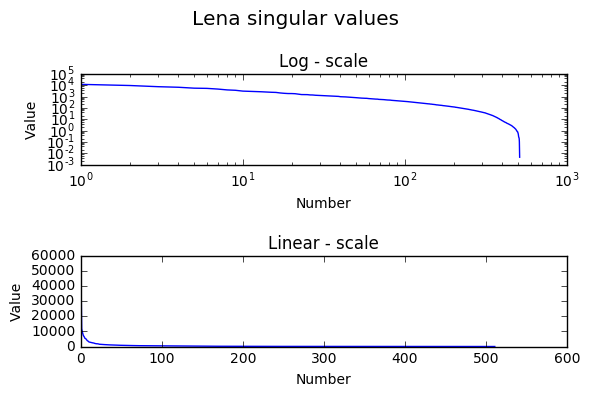

In [116]:
from PIL import Image
lena = Image.open('lenaTest3.jpg')
lena_svd = np.linalg.svd(lena)# Computing SVD

fig = pl.figure()
title = fig.suptitle("Lena singular values", fontsize="x-large")

log_sv = fig.add_subplot(2,1,1)
log_sv.plot(lena_svd[1])
log_sv.set_title('Log - scale')
log_sv.set_xscale('log')
log_sv.set_yscale('log')
log_sv.set_xlabel('Number')
log_sv.set_ylabel('Value')

lin_sv = fig.add_subplot(2,1,2)
lin_sv.plot(lena_svd[1])
lin_sv.set_title('Linear - scale')
lin_sv.set_xlabel('Number')
lin_sv.set_ylabel('Value')

pl.tight_layout()
fig.subplots_adjust(top=0.82, hspace=1)
pl.show()

In [7]:
r = [5, 20, 50, 512]

# pl.subplot(2,2,1)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[0]], np.diag(lena_svd[1][:r[0]])), lena_svd[2][:r[0],:])
# pl.imshow(lena_compr_r, cmap = 'gray')

# pl.subplot(2,2,2)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[1]], np.diag(lena_svd[1][:r[1]])), lena_svd[2][:r[1],:])
# pl.imshow(lena_compr_r, cmap = 'gray')

# pl.subplot(2,2,3)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[2]], np.diag(lena_svd[1][:r[2]])), lena_svd[2][:r[2],:])
# pl.imshow(lena_compr_r, cmap = 'gray')

# pl.subplot(2,2,4)
# lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[3]], np.diag(lena_svd[1][:r[3]])), lena_svd[2][:r[3],:])
# pl.imshow(lena_compr_r, cmap = 'gray')


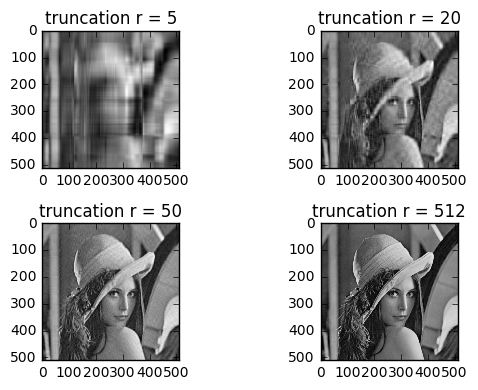

In [8]:
for i in range(len(r)):
    pl.subplot(2, 2, i+1)
    pl.title(("truncation r = %s") % r[i])
    lena_compr_r = np.dot(np.dot(lena_svd[0][:,:r[i]], np.diag(lena_svd[1][:r[i]])), lena_svd[2][:r[i],:])
    pl.imshow(lena_compr_r, cmap = 'gray')
    
pl.tight_layout()

# Problem 5 (Bonus)

* The norm is called absolute if $\|x\|=\| \lvert x \lvert \|$ holds for any vector $x$, where $x=(x_1,\dots,x_n)^T$ and $\lvert x \lvert = (\lvert x_1 \lvert,\dots, \lvert x_n \lvert)^T$. Give an example of a norm which is not absolute.


* Write a function ```HOSVD(n, epsilon)``` that calculates High-Order SVD (HOSVD) algorithm in 3D and returns core and 3 HOSVD factors (```epsilon``` is the relative accuracy in the Frobenius norm between approximated and initial tensors). Give ranks of the 3D Hilbert tensor
$$
a_{ijk} = \frac{1}{i+j+k + 1}, \quad i,j,k = 0,\dots, n-1
$$
with $10^{-5}$ accuracy. Details can be found [here](http://ca.sandia.gov/~tgkolda/pubs/pubfiles/TensorReview.pdf) on Figure 4.3.

# Solution
* Spectral norm is not an absolute norm.

$$\left|\left| \begin{bmatrix}
4 && 7 \\
10 && -5
\end{bmatrix} \right|\right|_2 = 9$$

$$\left|\left| \begin{bmatrix}
4 && 7 \\
10 && 5
\end{bmatrix} \right|\right|_2 = 12.8815$$
